#GAN이론
GAN: 적대적 생성 신경망

1. Z  ->(Gen:생성기)-> G(Z)

2. X  ->(Dis:분류기)-> D(X)
  
  G(Z)->(Dis:분류기)-> D(Z(X))

학습 분류 : 비지도 학습(따라 그리는 것이 아닌 마음대로 그리는, 지도받지않는 그림)

##(분류기의)목표
- 생성확신도: $P_{Dis} (G(z)) = D(G(z))$ 는 최소화
- 원래 이미지 확신도 : $P_{Dis} (X) = D(X)$ 는 극대화

$ L = - \frac{1}{m} ∑ (log(D(X))+log(1-D(G(Z))))$

Z: 잡음이미지(흑백으로 치지직 하는 이미지)

Gen: 생성 신경망 (Generator) : 위조 지폐범 역

G(Z) : 생성이미지 획득(생성기가 잘 학습 되어있다면 유의미한 결과 이미지 도출 가능)

X : 원래 이미지

Dis : 분류기(Discriminator)에 X와 G(Z)를 동시에 입력받음 : 위조 지폐 감별사 역

D(X), D(Z(X)) : 원래이미지(T), 생성이미지(F) 분류

이전 단계결과에 대한 적대적 학습 시행 : 생성 이미지 출신 저하, 원래이미지 출신 상승

## 손실함수 분석
- $L_{d} = - \frac{1}{m} ∑ (log(D(X))+log(1-D(G(Z))))$

$L_{d}$: 손실함수(Loss.backward() \ optimizer.step())

$\frac{1}{m} ∑$ : 평균(torch.mean)

$log(D(X))$ : 원래 이미지 분류기 확률 분포 높이기, $P_{Dis}(X)$ 

$log(1-D(G(Z)))$ : 생성 이미지 분류기 확률분포 줄이기, $P_{Dis}(G(Z))$ 

- $L_{g} = \frac{1}{m} ∑ log(1-D(G(Z)))$

log(1-D(G(Z))) : 생성이미지 분류기 확률분포 늘이기, $P_{g}(G(Z))$

## 생성자와 분류자가 서로 경쟁적으로 학습하며 **진짜와 구분할 수 없는 가짜를 만들어내는 생성자** 를 얻을 수 있음

## DCGAN using pytorch

- Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks
- Alec Radford,Luke Metz,Soumith Chintala(2016)
- https://arxiv.org/pdf/1511.06434.pdf

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### setting parameters

In [3]:
num_batch = 128
image_size = 64  #(width, height, channel) --> (64,64,3)
nz = 100 # noise size

total_epochs = 5
learning_rate = 2e-04

## CelebA dataset download

In [4]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

import os
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

--2022-01-19 06:37:19--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.113.40
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.113.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  19.7MB/s    in 71s     

2022-01-19 06:38:31 (19.4 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]

202599


In [5]:
datasets = torchvision.datasets.ImageFolder(root = './data_faces',
                            transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
dataloader = torch.utils.data.DataLoader(datasets,batch_size=num_batch,shuffle=True,drop_last=False)

torch.Size([128, 3, 64, 64])


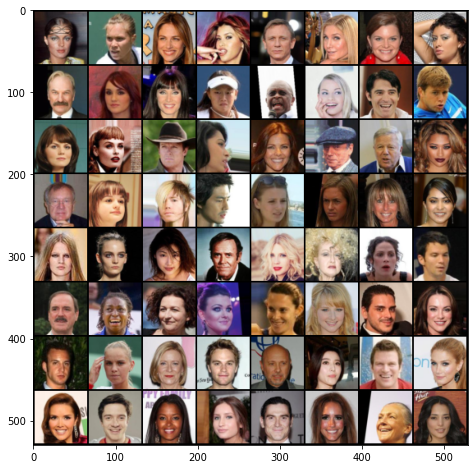

In [6]:
batch = next(iter(dataloader))
print(batch[0].shape)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(torchvision.utils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
# trick - initial weight on Generator and Discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# 잡음생성함수
def gen_z(batch_size,noise_size):
    return np.random.normal(size=(batch_size,noise_size)) #z (batch,100)

#### DCGAN Generator image

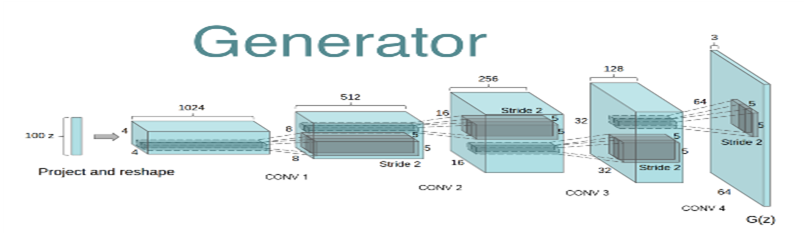

In [9]:
'''
Generator architecture

input (batch,nz,1,1)

            in_channel    out_channel   kernel    stride   padding  result
conv2d.T    nz            64*8          (4,4)     (1,1)    0        64*8,4,4
batchnorm
conv2d.T    64*8          64*4          (4,4)     (2,2)    (1,1)    64*4,8,8
batchnorm
con2d.T     64*4          64*2          (4,4)     (2,2)    (1,1)    64*2,16,16
batchnorm
conv2d.T    64*2          64            (4,4)     (2,2)    (1,1)    64,32,32
batchnorm
conv2d.T    64            3             (4,4)     (2,2)    (1,1)    3,64,64
'''
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, 64*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64*8),
            nn.ReLU(),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(),
            nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(),
            nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)

#### DCGAN Discirimator


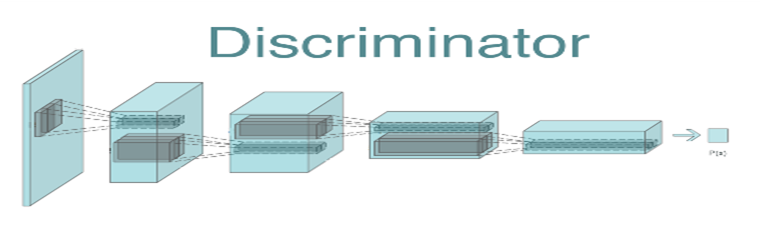

In [10]:
'''
Discriminator architecture

input (batch,3,64,64)

            in_channel    out_channel   kernel    stride   padding  result
conv2d      3             64            (4,4)     (2,2)    (1,1)    64,32,32
conv2d      64            64*2          (4,4)     (2,2)    (1,1)    64*2,16,16
batchnorm
con2d       64*2          64*4          (4,4)     (2,2)    (1,1)    64*4,8,8
batchnorm
conv2d      64*4          64*8          (4,4)     (2,2)    (1,1)    64*8,4,4
batchnorm
conv2d      64*8          1             (4,4)     (1,1)    (0,0)    1,1,1
'''

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        x = self.main(x)
        return x

In [11]:
G_model = Generator().to(device)
G_model.apply(weights_init)
D_model = Discriminator().to(device)
D_model.apply(weights_init)

optimizerG = optim.Adam(G_model.parameters(),lr=learning_rate)
optimizerD = optim.Adam(D_model.parameters(),lr=learning_rate)

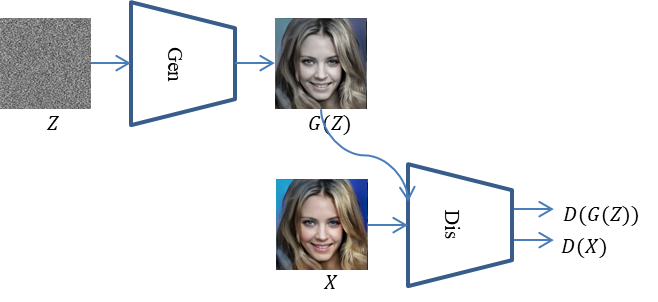

#### Discriminator & Genrator objective function

분류기 손실함수 --> 생성모델 확률감소 + 원 이미지 확률 상승

$L_d = -{{1}\over{m}}\sum{(log(D(X))+log(1-D(G(z)))}$

생성자 손실함수 --> 생성모델 확률상승

$L_g = {{1}\over{m}}\sum{log(1-D(G(z)))}$

In [12]:
def Discriminator_loss(D_x,D_gz):
    '''
    D_x : 원래 이미지 확률
    D_gz: 생성 이미지 확률
    '''
    return -torch.mean(torch.log(D_x+1e-15)+torch.log(1-D_gz+1e-15))

def Generator_loss(D_gz):
    '''
    D_gz: 생성이미지 확률
    '''
    #return torch.mean(torch.log(1-D_gz)) : 이론적으론 이게 맞지만 실질적으로는 아래의 식이 더 학습이 빨리 끝남
    return -torch.mean(torch.log(D_gz+1e-15))

In [13]:
D_loss, G_loss = [],[]
for ep in range(total_epochs):
    d_, g_ = 0, 0,
    for X in dataloader:
        X = X[0].to(device)

        # Discriminator 학습
        D_model.zero_grad()
        Z = gen_z(X.shape[0],nz)
        Z = torch.Tensor(Z).view(Z.shape[0],nz,1,1).to(device)
        gz = G_model(Z)
        D_gz = D_model(gz).view(-1,1)
        D_x = D_model(X)

        loss_d = Discriminator_loss(D_x,D_gz)
        loss = loss_d
        d_ += loss.item()
        optimizerD.zero_grad()
        loss.backward()
        optimizerD.step()

        # Generator 학습
        G_model.zero_grad()
        gz = G_model(Z)
        D_gz = D_model(gz).view(-1,1)
        loss_g = Generator_loss(D_gz)
        loss = loss_g
        g_ += loss.item()
        optimizerG.zero_grad()
        loss.backward()
        optimizerG.step()

    print('Epoch {}, Discriminator loss {}, Generator loss {}'.format(ep,d_/len(dataloader),g_/len(dataloader)))

Epoch 0, Discriminator loss 0.048827017574364404, Generator loss 10.184182893303626
Epoch 1, Discriminator loss 0.03554658234496961, Generator loss 10.421364590553868
Epoch 2, Discriminator loss 0.04460994585680524, Generator loss 10.5215984773425
Epoch 3, Discriminator loss 0.07122701198707246, Generator loss 9.35029430488808
Epoch 4, Discriminator loss 0.054660152571787385, Generator loss 9.000737060419157


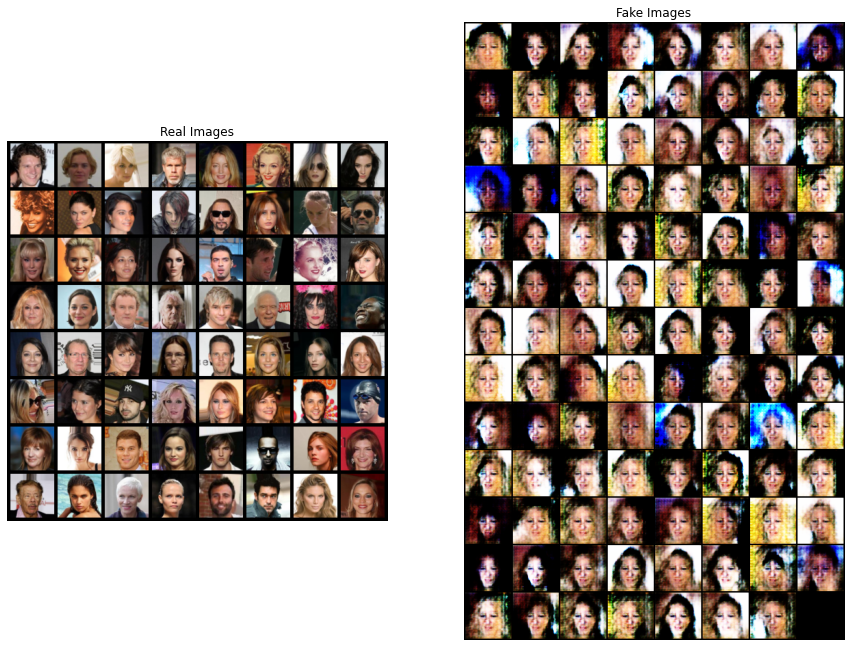

In [14]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


gz = gz.detach().cpu()
img_list.append(torchvision.utils.make_grid(gz, padding=2, normalize=True))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()